In [10]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [11]:
import os
import shutil
import stat
import seaborn as sns
import collections
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.image as img
import random
import cv2
import PIL
import matplotlib.pyplot as plt
import matplotlib.image as img
from os import listdir
from os.path import isfile, join
from collections import defaultdict
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from sklearn.model_selection import train_test_split
from skimage.io import imread
from keras.utils.np_utils import to_categorical
from keras.applications.inception_v3 import preprocess_input
from keras.models import load_model
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend 
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models
from skimage.io import imread
import matplotlib.pyplot as plt


%matplotlib inline

In [ ]:
class_N = {}
N_class = {}
with open('/content/drive/MyDrive/pstone/food-101/meta/classes.txt', 'r') as txt:
    classes = [i.strip() for i in txt.readlines()]
    class_N = dict(zip(classes, range(len(classes))))
    N_class = dict(zip(range(len(classes)), classes))
    class_N = {i: j for j, i in N_class.items()}
class_N_sorted = collections.OrderedDict(sorted(class_N.items()))
print(class_N)

# Method to generate directory-file map. 
def gen_dir_file_map(path):
    dir_files = defaultdict(list)
    with open(path, 'r') as txt:
        files = [i.strip() for i in txt.readlines()]
        for f in files:
            dir_name, id = f.split('/')
            dir_files[dir_name].append(id + '.jpg')
    return dir_files

# Method to recursively copy a directory.  
def copytree(source, target, symlinks = False, ignore = None):
  if not os.path.exists(target):
      os.makedirs(target)
      shutil.copystat(source, target)
  data = os.listdir(source)
  if ignore:
      exclude = ignore(source, data)
      data = [x for x in data if x not in exclude]
  for item in data:
      src = os.path.join(source, item)
      dest = os.path.join(target, item)
      if symlinks and os.path.islink(src):
          if os.path.lexists(dest):
              os.remove(dest)
          os.symlink(os.readlink(src), dest)
          try:
              st = os.lstat(src)
              mode = stat.S_IMODE(st.st_mode)
              os.lchmod(dest, mode)
          except:
              pass
      elif os.path.isdir(src):
          copytree(src, dest, symlinks, ignore)
      else:
          shutil.copy2(src, dest)

# Train files to ignore. 
def ignore_train(d, filenames):
  subdir = d.split('/')[-1]
  train_dir_files = gen_dir_file_map('/content/drive/MyDrive/pstone/food-101/meta/train.txt')
  to_ignore = train_dir_files[subdir]
  return to_ignore

# Test files to ignore.    
def ignore_test(d, filenames):
  subdir = d.split('/')[-1]
  test_dir_files = gen_dir_file_map('/content/drive/MyDrive/pstone/food-101/meta/test.txt')
  to_ignore = test_dir_files[subdir]
  return to_ignore

import os
import cv2
import numpy as np
from os import listdir
from os.path import join

def load_images(path_to_imgs):
    resize_count = 0
    invalid_count = 0
    all_imgs = []
    all_classes = []
    invalid_images = []  # List to store the names of invalid images

    for i, subdir in enumerate(listdir(path_to_imgs)):
        imgs = listdir(join(path_to_imgs, subdir))
        classN = class_N[subdir]
        for img_name in imgs:
            img_path = join(path_to_imgs, subdir, img_name)
            if os.path.isfile(img_path):
                img_arr = cv2.imread(img_path)
                if img_arr is not None:
                    img_arr_rs = cv2.resize(img_arr, (200, 200), interpolation=cv2.INTER_AREA)
                    resize_count += 1
                    im_rgb = cv2.cvtColor(img_arr_rs, cv2.COLOR_BGR2RGB)
                    all_imgs.append(im_rgb)
                    all_classes.append(classN)
                else:
                    invalid_count += 1
                    invalid_images.append(img_name)  # Store the name of the invalid image
            else:
                invalid_count += 1
                invalid_images.append(img_name)  # Store the name of the invalid image
    
    print(f"Resized images: {resize_count}")
    print(f"Invalid images: {invalid_count}")
    print("Invalid image names:", invalid_images)  # Print the names of the invalid images
    
    return np.array(all_imgs), np.array(all_classes)





# Method to generate train-test files. 
def gen_train_test_split(path_to_imgs = '/content/drive/MyDrive/pstone/food-101/images' , target_path = '/content/drive/MyDrive/pstone/food-101'):
  copytree(path_to_imgs, target_path + '/train', ignore=ignore_test)
  copytree(path_to_imgs, target_path + '/test', ignore=ignore_train)

# Method to load train-test files.
def load_train_test_data(path_to_train_imgs, path_to_test_imgs):
  X_train, y_train = load_images(path_to_train_imgs)
  X_test, y_test = load_images(path_to_test_imgs)
  return X_train, y_train, X_test, y_test


{'apple_pie': 0, 'baby_back_ribs': 1, 'baklava': 2, 'beef_carpaccio': 3, 'beef_tartare': 4}


In [ ]:
# Generate train-test files. 
if not os.path.isdir('/content/drive/MyDrive/pstone/food-101/test') and not os.path.isdir('/content/drive/MyDrive/pstone/food-101/train'):
    gen_train_test_split()  
    len_train = len(os.listdir('/content/drive/MyDrive/pstone/food-101/train'))
    len_test = len(os.listdir('/content/drive/MyDrive/pstone/food-101/test'))
    print(len_train,len_test)
else:
    print('train and test folders already exists.')
    len_train = len(os.listdir('/content/drive/MyDrive/pstone/food-101/train'))
    len_test = len(os.listdir('/content/drive/MyDrive/pstone/food-101/test'))
    print(len_train,len_test)

train and test folders already exists.
5 5


In [ ]:
# List of all the food classes.
foods_sorted = sorted(os.listdir('/content/drive/MyDrive/pstone/food-101/images'))
foods_sorted

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

(384, 512, 3)


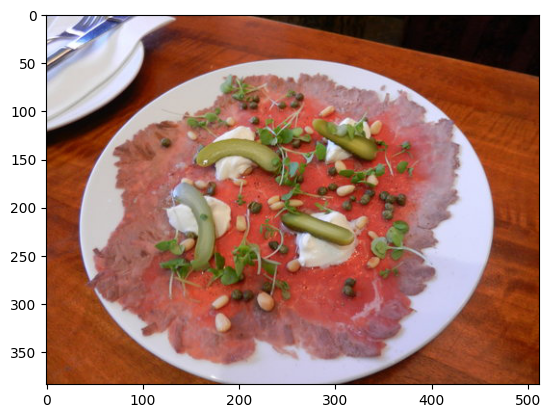

In [ ]:
# Display an image. Brb. Gtg and get a waffle for myself. :P
testImg = imread('/content/drive/MyDrive/pstone/food-101/train/beef_carpaccio/1011469.jpg')
print(testImg.shape)
plt.imshow(testImg)

In [ ]:
X_train, y_train, X_test, y_test = load_train_test_data('/content/drive/MyDrive/pstone/food-101/train','/content/drive/MyDrive/pstone/food-101/test')

Resized images: 7502
Invalid images: 0
Invalid image names: []
Resized images: 4154
Invalid images: 0
Invalid image names: []


In [9]:
import tensorflow.keras.backend as K

K.clear_session()

n_classes = 5
batch_size = 32
width, height = 200, 200
train_data = '/content/drive/MyDrive/pstone/food-101/train'
test_data = '/content/drive/MyDrive/pstone/food-101/test'
train_samples = 7502
test_samples = 4154

train_data_gen = ImageDataGenerator(rescale=1. / 255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_data_gen = ImageDataGenerator(rescale=1. / 255)

train_gen = train_data_gen.flow_from_directory(train_data, target_size=(height, width), batch_size=batch_size, class_mode='categorical')

test_gen = test_data_gen.flow_from_directory(test_data, target_size=(height, width), batch_size=batch_size, class_mode='categorical')

inception = InceptionV3(weights='imagenet', include_top=False)
layer = inception.output
layer = GlobalAveragePooling2D()(layer)
layer = Dense(128, activation='relu')(layer)
layer = Dropout(0.2)(layer)
predictions = Dense(n_classes, kernel_regularizer=regularizers.l2(0.005), activation='softmax')(layer)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='best_model_101class.hdf5', save_best_only=True)
csv_logger = CSVLogger('history_101class.log')

history_101class = model.fit_generator(
    train_gen,
    steps_per_epoch=len(train_gen),
    validation_data=test_gen,
    validation_steps=len(test_gen),
    epochs=5,
    callbacks=[csv_logger, checkpointer],
    verbose=1
)

model.save('model_trained_101class.hdf5')


Found 7502 images belonging to 5 classes.
Found 4154 images belonging to 5 classes.


<ipython-input-9-31945dceca61>:33: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_101class = model.fit_generator(


Epoch 1/5
235/235 [==============================] - 4050s 17s/step - loss: 0.8760 - accuracy: 0.6838 - val_loss: 0.3563 - val_accuracy: 0.8972
Epoch 2/5
235/235 [==============================] - 3852s 16s/step - loss: 0.3826 - accuracy: 0.8788 - val_loss: 0.1960 - val_accuracy: 0.9574
Epoch 3/5
235/235 [==============================] - 3754s 16s/step - loss: 0.2557 - accuracy: 0.9259 - val_loss: 0.1245 - val_accuracy: 0.9769
Epoch 4/5
235/235 [==============================] - 3793s 16s/step - loss: 0.1731 - accuracy: 0.9599 - val_loss: 0.1009 - val_accuracy: 0.9827
Epoch 5/5
235/235 [==============================] - 3901s 17s/step - loss: 0.1446 - accuracy: 0.9675 - val_loss: 0.0857 - val_accuracy: 0.9882


In [12]:
class_map_101 = train_gen.class_indices
class_map_101

{'apple_pie': 0,
 'baby_back_ribs': 1,
 'baklava': 2,
 'beef_carpaccio': 3,
 'beef_tartare': 4}

<ipython-input-13-fd5a403e9bf0>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  _ = plt.style.library['seaborn-darkgrid']


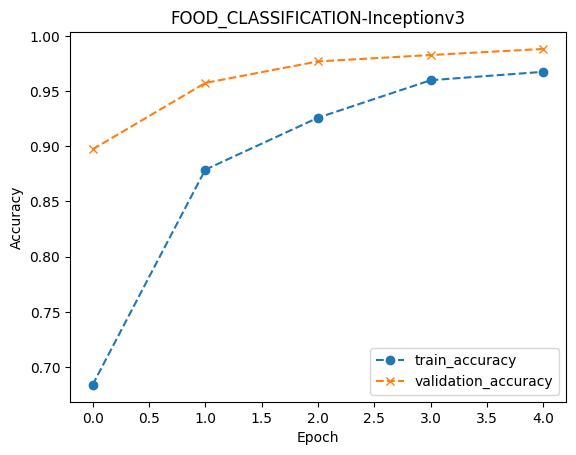

In [13]:
# Plot training-accuracy & validation-accuracy.
_ = plt.style.library['seaborn-darkgrid']
_ = plt.title('FOOD_CLASSIFICATION-Inceptionv3')
_ = plt.plot(history_101class.history['accuracy'], marker='o', linestyle='dashed')
_ = plt.plot(history_101class.history['val_accuracy'], marker='x', linestyle='dashed')
_ = plt.ylabel('Accuracy')
_ = plt.xlabel('Epoch')
_ = plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
plt.show()

<ipython-input-14-b52c8654d1d7>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  _ = plt.style.library['seaborn-darkgrid']


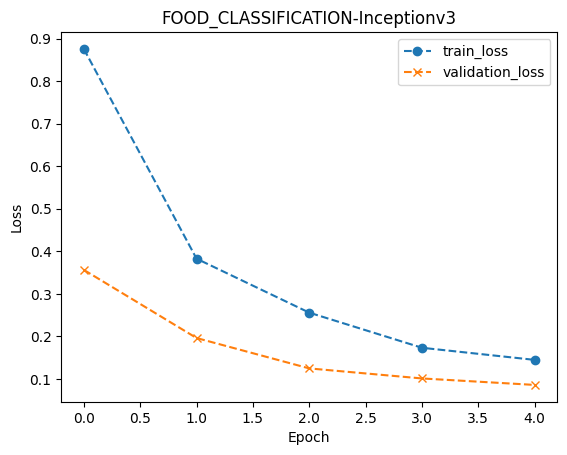

In [14]:
# Plot training-loss & validation-loss.
_ = plt.style.library['seaborn-darkgrid']
_ = plt.title('FOOD_CLASSIFICATION-Inceptionv3')
_ = plt.plot(history_101class.history['loss'], marker='o', linestyle='dashed')
_ = plt.plot(history_101class.history['val_loss'], marker='x', linestyle='dashed')
_ = plt.ylabel('Loss')
_ = plt.xlabel('Epoch')
_ = plt.legend(['train_loss', 'validation_loss'], loc='best')
plt.show()

In [15]:
# Loading the best saved model to make predictions.
tensorflow.keras.backend.clear_session()
model_best = load_model('best_model_101class.hdf5',compile = False)
# Downloading some test images.
!wget -O speghetticarbonara.jpg https://food.fnr.sndimg.com/content/dam/images/food/fullset/2015/12/1/3/WU1207H_Spaghetti-Carbonara_s4x3.jpg.rend.hgtvcom.826.620.suffix/1452882192060.jpeg

--2023-06-06 07:03:55--  https://food.fnr.sndimg.com/content/dam/images/food/fullset/2015/12/1/3/WU1207H_Spaghetti-Carbonara_s4x3.jpg.rend.hgtvcom.826.620.suffix/1452882192060.jpeg
Resolving food.fnr.sndimg.com (food.fnr.sndimg.com)... 104.127.171.98
Connecting to food.fnr.sndimg.com (food.fnr.sndimg.com)|104.127.171.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71254 (70K) [image/jpeg]
Saving to: ‘speghetticarbonara.jpg’

speghetticarbonara. 100%[===================>]  69.58K  --.-KB/s    in 0.05s   

2023-06-06 07:03:55 (1.39 MB/s) - ‘speghetticarbonara.jpg’ saved [71254/71254]



In [19]:
import pandas as pd

csv_path = '/content/drive/MyDrive/pstone/calorie bangkit.csv'
dataset = pd.read_csv(csv_path)


1/1 [==============================] - 0s 343ms/step


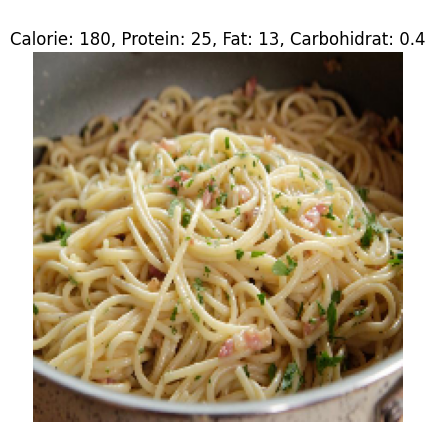

In [22]:
def predict_class(model, images, show=True): 

    for img in images:
        img = image.load_img(img, target_size=(200, 200))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = img / 255.

        pred = model.predict(img)
        index = np.argmax(pred)
        pred_value = foods_sorted[index]

        # Retrieve additional information from the dataset based on the predicted food
        food_info = dataset[dataset['Food_Name'] == pred_value]
        calorie = food_info['Calorie'].values[0]
        protein = food_info['Protein'].values[0]
        fat = food_info['Fat'].values[0]
        carbohydrate = food_info['Carbohidrat'].values[0]

        if show:
            plt.imshow(img[0])
            plt.axis('off')
            plt.title(f"\nCalorie: {calorie}, Protein: {protein}, Fat: {fat}, Carbohidrat: {carbohydrate}")
            plt.show()
images = ['speghetticarbonara.jpg']
predict_class(model_best, images, True)

In [21]:
def predict_class(model, images): 
    results = []

    for img_path in images:
        img = image.load_img(img_path, target_size=(200, 200))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = img / 255.

        pred = model.predict(img)
        index = np.argmax(pred)
        pred_value = foods_sorted[index]

        # Retrieve additional information from the dataset based on the predicted food
        food_info = dataset[dataset['Food_Name'] == pred_value]
        calorie = food_info['Calorie'].values[0]
        protein = food_info['Protein'].values[0]
        fat = food_info['Fat'].values[0]
        carbohydrate = food_info['Carbohidrat'].values[0]

        result = f"Calorie: {calorie}, Protein: {protein}, Fat: {fat}, Carbohidrat: {carbohydrate}"
        results.append(result)

    return results[0] if results else None
images = ['speghetticarbonara.jpg']
predict_class(model_best, images)

1/1 [==============================] - 0s 149ms/step


'Calorie: 180, Protein: 25, Fat: 13, Carbohidrat: 0.4'